# Regression Kriging Model

## setup

In [1]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# vector geo data libs
import pandas as pd
import geopandas as gpd
import contextily as cx
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 500)
# kriging
from pykrige.rk import RegressionKriging
import pykrige.kriging_tools as kt
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [4]:
# importing datasets
data_lu = gpd.read_file('..\\output\\data_lu_1.GEOJSON', engine='pyogrio')
data_sp = gpd.read_file('..\\output\\data_sp_1.GEOJSON', engine='pyogrio')
data_oz = gpd.read_file('..\\output\\data_oz_1.GEOJSON', engine='pyogrio')

In [19]:
# utils to fetch only (in)dependent vars
def get_X_arr(df, cols=['maxspeed', 'bridge',
       'junction', 'rt_highway', 'rt_trunk', 'rt_primary', 'rt_secondary',
       'rt_tertiary', 'rt_unclassified', 'rt_residential', 'rt_living_street',
       'rt_busway', 'rt_service', 'dist_to_train', 'dist_to_recreation',
       'landuse_is_residential', 'landuse_is_commercial',
       'landuse_is_industrial', 'building_height']):
    return df[cols].values
def get_y_arr(df, y='dBA_reg'):
    return df[y].values
def get_c_arr(df, c=['x', 'y']):
    return df[c].values

# creating train-test-pred splits
measurement_col = 'dBA_reg'
train_lu, test_lu = train_test_split(data_lu[data_lu[measurement_col].notna()], test_size=0.3)
pred_lu = data_lu[data_lu[measurement_col].isna()]
train_sp, test_sp = train_test_split(data_sp[data_sp[measurement_col].notna()], test_size=0.3)
pred_sp = data_sp[data_sp[measurement_col].isna()]
train_oz, test_oz = train_test_split(data_oz[data_oz[measurement_col].notna()], test_size=0.3)
pred_oz = data_oz[data_oz[measurement_col].isna()]

## Baseline Models

In [58]:
svr_model = SVR(C=0.1, gamma="auto")
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]
areas = [('lunetten', train_lu, test_lu, pred_lu, data_lu),
         ('science park', train_sp, test_sp, pred_sp, data_sp),
         ('oud zuilen', train_oz, test_oz, pred_oz, data_oz),]


preds, min_pred, max_pred = {str(m): {} for m in models}, np.inf, -np.inf

for x, m in enumerate(models):
    for y, (area, train_a, test_a, pred_a, data_a) in enumerate(areas):
        print("=" * 40)
        print("regression model:", m.__class__.__name__)
        print(f"area: {area} (y:{y},x:{x})")
        m_rk = RegressionKriging(regression_model=m, n_closest_points=10)
        m_rk.fit(get_X_arr(train_a), get_c_arr(train_a), get_y_arr(train_a))
        print("Regression Score: ", m_rk.regression_model.score(get_X_arr(test_a), get_y_arr(test_a)))
        print("RK score: ", m_rk.score(get_X_arr(test_a), get_c_arr(test_a), get_y_arr(test_a)))
        pred = m_rk.predict(get_X_arr(data_a), get_c_arr(data_a))
        min_pred = min(min_pred, min(pred)); max_pred = max(max_pred, max(pred))
        preds[str(m)][area] = pred

regression model: SVR
area: lunetten (y:0,x:0)
Finished learning regression model
Finished kriging residuals
Regression Score:  0.003088794757102331
RK score:  0.8425395498441268
regression model: SVR
area: science park (y:1,x:0)
Finished learning regression model
Finished kriging residuals
Regression Score:  0.007888963202385302
RK score:  0.7048604005140209
regression model: SVR
area: oud zuilen (y:2,x:0)
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.05337210413141391
RK score:  0.6196462135065465
regression model: RandomForestRegressor
area: lunetten (y:0,x:1)
Finished learning regression model
Finished kriging residuals
Regression Score:  0.8225799591709211
RK score:  0.8286242679301077
regression model: RandomForestRegressor
area: science park (y:1,x:1)
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7074428844107052
RK score:  0.7464963405975613
regression model: RandomForestRegressor
area: oud zuilen (y:2,x

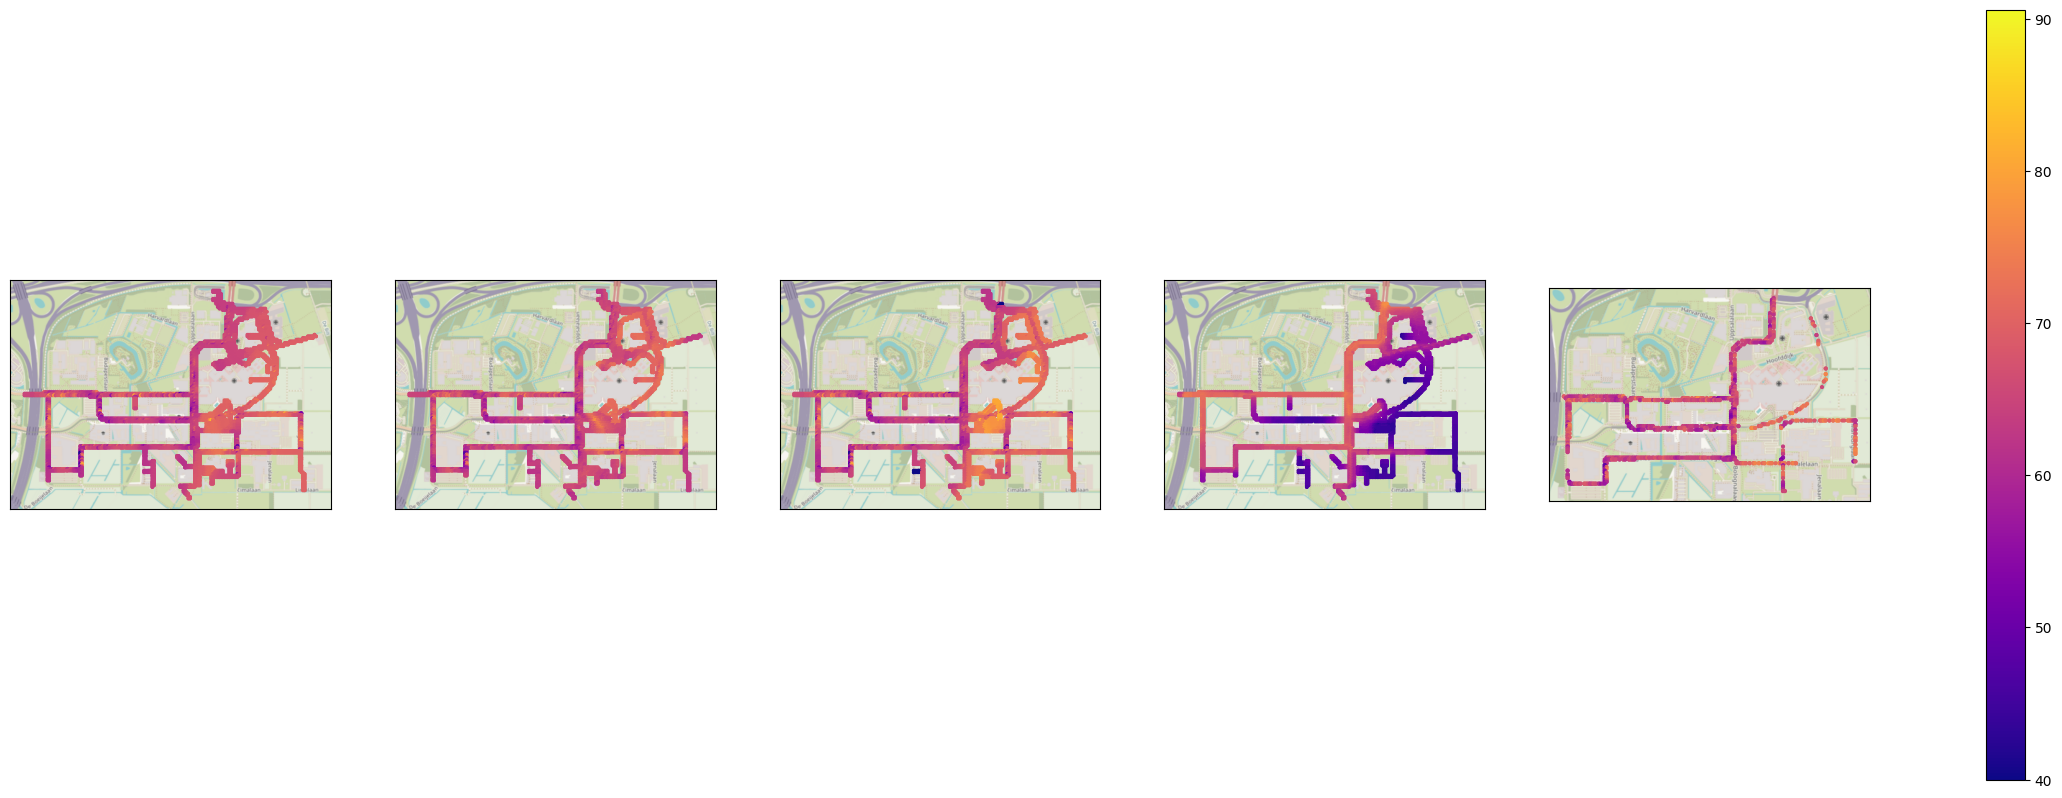

In [66]:
# fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30,30))
# norm, cmap = mpl.colors.Normalize(vmin=40, vmax=max_pred), 'plasma'
# for x, m in enumerate(models):
#     print(str(m))
#     for y, (area, train_a, test_a, pred_a, data_a) in enumerate(areas):
#         vis_df = gpd.GeoDataFrame(data={'pred': preds[y][x]},
#                                   geometry=data_a['geometry'], crs=data_a.crs)
#         vis_df.plot(column='pred', ax=axs[y][x], markersize=3, norm=norm, cmap=cmap)
#         axs[y][x].set_xticks([]); axs[y][x].set_yticks([])
#         cx.add_basemap(ax=axs[y][x], crs=vis_df.crs, attribution=False)

# fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs)
# fig.show()

area_data = data_sp
area_name = 'science park'
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,10))
norm, cmap = mpl.colors.Normalize(vmin=40, vmax=max_pred), 'plasma'

for x, m in enumerate(models):
    vis_df = gpd.GeoDataFrame(data={'pred': preds[str(m)][area_name]},
                            geometry=area_data['geometry'], crs=area_data.crs)
    vis_df.plot(column='pred', ax=axs[x], markersize=3, norm=norm, cmap=cmap)
    axs[x].set_xticks([]); axs[x].set_yticks([])
    cx.add_basemap(ax=axs[x], crs=vis_df.crs, attribution=False)

area_data.plot(column='dBA_rivm', ax=axs[3], markersize=3, norm=norm, cmap=cmap)
axs[3].set_xticks([]); axs[3].set_yticks([])
cx.add_basemap(ax=axs[3], crs=area_data.crs, attribution=False)

area_data.plot(column='dBA_reg', ax=axs[4], markersize=4, norm=norm, cmap=cmap)
axs[4].set_xticks([]); axs[4].set_yticks([])
cx.add_basemap(ax=axs[4], crs=area_data.crs, attribution=False)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs)
print()

## Model Selection 

In [ ]:
from sklearn.model_selection import GroupKFold, cross_val_predict
cities = df['city'].values
group_kfold = GroupKFold(n_splits=5) # Generator for the train/test indices
city_kfold = group_kfold.split(X, y, cities)  # Create a nested list of train and test indices for each fold
train_indices, test_indices = [list(traintest) for traintest in zip(*city_kfold)]
city_cv = [*zip(train_indices,test_indices)]
predictions = cross_val_predict(model, X, y, cv=city_cv)

In [ ]:
# Linear
# SVM
# KernelRidge
# RF
# Gradient Boost